# AMR SKID-STEERING PROJECT
### Notebook contents
* Kinodynamic RRT* implementation
### Notebook contributors
* Mattia Castelmare
* Andrea Giuseppe Di Francesco
* Enrico Fazzi

## Imports

In [1]:
import numpy as np
import math
from env import *
from plotting import *
import copy
import random
from utils import *
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np


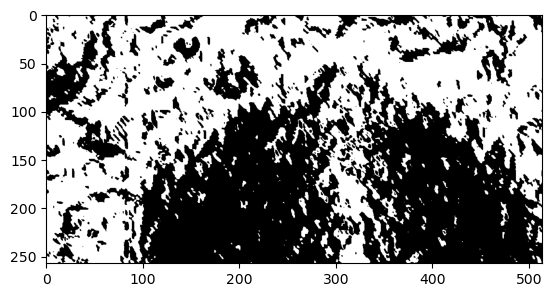

In [7]:
p = get_new_map(np.load('numpy_maps/apollo15_landing_site.npy'), 'apollo15_landing_site')
extent = [0, p.shape[1]/res, p.shape[0]/res, 0] # Get correct resolution of the image

# plt.imshow(p, cmap = 'gray', extent = extent)


plt.imshow(1-trav_map, cmap = 'gray', extent = extent)

## Kin Traj Plan

In [2]:
class KinoDynamicTrajectoryPlanner:

    def __init__(self, qi, qf, jerk = False):

        self.qi = qi
        self.qf = qf
        self.jerk = jerk

        self.A, self.B, self.R = self.get_AB(self.qf) # Linearize around the final state qf
    
        self.q_d_0 = self.get_state(self.qf, 0, 0) # Computed with the zero inputs
        
        self.c = self.q_d_0 - self.A @ self.qf
      
        
        
        
    def plan_opt_traj(self):


        tau = 0.0
        tau_step = 1
        interstar = 0
        iter_max = 1000000

        c = np.zeros((iter_max))
        xbar = np.zeros((iter_max, *self.qi.shape))
        G = np.zeros((iter_max, *self.A.shape))

        c[interstar] = np.inf
        G[0] = np.zeros((self.A.shape))
        iter = 0
        xbar[0] = self.qi
        while tau < c[interstar]:
            
            tau+= tau_step
            iter += 1
            xbar[iter] = self.our_RK4(self.x_bar, xbar[0], tau)
            G[iter] = self.our_RK4(self.G_func, G[0], tau)
            
            #G[iter] += 0.001*np.eye(G[iter].shape[0])
            c[iter] = self.compute_cost(G[iter], xbar[iter], tau)
            

            if c[iter] < c[interstar]:
                interstar = iter
                taustar = tau
            # print(tau)

        # print('Found time: ', taustar)
        d_ = np.linalg.inv(G[interstar]) @ (self.qf - xbar[interstar])
        self.Time = taustar
        # print(self.qf.shape, d_.shape)
        state_f = np.concatenate([self.qf, d_])
        self.confs, self.ys = self.our_BKRK4(self.ODE_state_rec, state_f, taustar)
        pre_c = np.linalg.inv(self.R) @ self.B.T
        pre_c = np.expand_dims(pre_c, axis = 0)

        pre_c = np.repeat(pre_c, self.confs.shape[0], axis = 0)

        self.commands = pre_c @ self.ys
        self.cost = c[interstar]

        # Flipping the arrays:
        self.confs = np.flip(self.confs, axis = 0)
        self.commands = np.flip(self.commands, axis = 0)


        return self.confs[-1]
    
    def get_state(self, state, u1, u2): #eta1, eta2, theta, u1, u2):
        ''' This function return the state of the system:
        
            args: eta1, eta2, theta, u1, u2: Configuration space;

            output: q = current state computed in eta1, eta2, theta, u1, u2
        '''
        if not self.jerk:
            theta, eta1, eta2 = state[2][0], state[3][0], state[4][0]
            
            q = np.array([[math.cos(theta)*eta1 - math.sin(theta)*eta2],
                        [math.sin(theta)*eta1 + math.cos(theta)*eta2],
                        [-(1/d0)*eta2],
                        [u1],
                        [u2]])
        else:
            theta, eta1, eta2, xi = state[2][0], state[3][0], state[4][0], state[5][0]
            r1, r2 = u1, u2
            q = np.array([[math.cos(theta)*eta1 - math.sin(theta)*eta2],
                        [math.sin(theta)*eta1 + math.cos(theta)*eta2],
                        [-(1/d0)*eta2],
                        [xi],
                        [(d0/eta1)*(math.sin(theta)*r1 - math.cos(theta)*r2) - (2/eta1)*xi*eta2],
                        [math.sin(theta)*r2 + math.cos(theta)*r1 + (eta1*eta2**2/d0**2)]])
            

        return q


    def get_derivative(self, q, u):
        ''' Compute the Kinematic model in a configuration q with a control input u'''
        qd = self.A @ q + self.B @ u + self.c

        return qd
    
    
    def ODE_state_rec(self, state):
        ''' This function computes the ODE to reconstruct the state, 5 variables are for the configuration q, and 5 for y. (Details in the paper) 

            args: state [10 x 1]

            output: [q_d, y_d]; concatenated transition vector.
        
        '''
        
        q_d = self.A @ state[:self.qi.shape[0], :] + self.B @ np.linalg.inv(self.R) @ self.B.T @ state[self.qi.shape[0]:, :] + self.c
        y_d = - self.A.T @ state[self.qi.shape[0]:, :]

        return np.concatenate([q_d, y_d])

    def get_AB(self, state):
        ''' This function return the A matrix that linearize the reduced kinematics in the skid-steering Robot :
        
            args: eta1, eta2, theta: Configuration space;

            output: A, B, R matrices
        '''
        if not self.jerk:

            theta, eta1, eta2 = state[2][0], state[3][0], state[4][0]


            A = np.array([[0, 0, -math.sin(theta)*eta1 - math.cos(theta)*eta2, math.cos(theta), -math.sin(theta)],
                        [0, 0, math.cos(theta)*eta1 - math.sin(theta)*eta2, math.sin(theta), math.cos(theta)],
                        [0, 0, 0, 0, -(1/d0)],
                        [0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0]])
            
            B = np.array([[0, 0],
                        [0, 0],
                        [0, 0],
                        [1, 0],
                        [0, 1]])
            R = np.array([[1000, 0],
                        [0, 10000]])
        else:
            theta, eta1, eta2, xi = state[2][0], state[3][0], state[4][0], state[5][0]
            
            A = np.array([[0, 0, -math.sin(theta)*eta1 - math.cos(theta)*eta2, math.cos(theta), -math.sin(theta), 0],
                        [0, 0, math.cos(theta)*eta1 - math.sin(theta)*eta2, math.sin(theta), math.cos(theta), 0],
                        [0, 0, 0, 0, -(1/d0), 0],
                        [0, 0, 0, 0, 0, 1],
                        [0, 0, 0, (2*xi*eta2/eta1**2), (-2*xi/eta1), (-2*eta2/eta1)],
                        [0, 0, 0, (eta2**2/d0**2), (2*eta1*eta2/d0**2), 0]])
            
            B = np.array([[0, 0],
                        [0, 0],
                        [0, 0],
                        [0, 0],
                        [(d0*math.sin(theta)/eta1), (-d0*math.cos(theta)/eta1)],
                        [math.cos(theta), math.sin(theta)]])
        
            R = np.array([[10000, 0],
                        [0, 10000]])

        
        return A, B, R



    def G_func(self, G_):
        
        ''' This function computes "The weighted controllability Gramian", given the A, B and R matrix of a system
            for which we aim to minimize a trajectory w/ fixed-final-state-fixed-final-time. 
            
            args: A, B: Linearized dynamics of the skid-steering Robot ; R: Weights matrix of the control inputs ; t: independent variable 

            output: G_: not integrated Weighted controllability Gramian matrix

        '''

        G_d = self.A @ G_ + G_ @ self.A.T + self.B @ np.linalg.inv(self.R) @ self.B.T #transition function
        
        
        return G_d
    

    def our_RK4(self, f, y0, tf):
        ''' This function computes a forward integration based on the 4-th order Runga-Kutta method 
        
            args: (f: Transition state function) ; (yf: Initial conditions) ; (tf: Final timestep)

            output: (y[-1]: Last value of the integrated function in tf)
        
        '''
        t = np.arange(0, tf, 2/(freq))
        # if tf not in t:
        #     t = np.concatenate((t, np.array([tf])))

        n = len(t)
        y = np.zeros((n, *y0.shape))
        y[0] = y0
        for i in range(n - 1):
            h = t[i+1] - t[i]
            k1 = f(y[i])
            k2 = f(y[i] + k1 * h / 2.)
            k3 = f(y[i] + k2 * h / 2.)
            k4 = f(y[i] + k3 * h)
            y[i+1] = y[i] + (h / 6.) * (k1 + 2*k2 + 2*k3 + k4)

        return y[-1]
    
    def our_BKRK4(self, f, yf, tf):
        ''' This function computes a backward integration based on the 4-th order Runga-Kutta method 
        
            args: (f: Transition state function) ; (yf: Final conditions) ; (tf: Initial timestep)

            output: (q: [N x state_variables x 1], trajectory of configurations in the Robot); (y_: [N x state_variables x 1], variable to compute the control inputs)
        
        '''

        t = np.flip(np.arange(0, tf, 1/freq))
        # if tf not in t:
        #     t = np.concatenate((np.array([tf]), t))

        n = len(t)
        y = np.zeros((n, *yf.shape))
        q = np.zeros((n, *self.qf.shape))
        y_ = np.zeros((n, *self.qf.shape))

        y[0] = yf
        q[0] = yf[:self.qf.shape[0]]
        y_[0] = yf[self.qf.shape[0]:]

        for i in range(n - 1):
            h = t[i+1] - t[i]
            k1 = f(y[i])
            k2 = f(y[i] + k1 * h / 2.)
            k3 = f(y[i] + k2 * h / 2.)
            k4 = f(y[i] + k3 * h)
            y[i+1] = y[i] + (h / 6.) * (k1 + 2*k2 + 2*k3 + k4)
            q[i+1] = y[i+1][:self.qf.shape[0]]

            #q[i+1][2] = 0 # Imposing theta equal to 0 doesn't change the trajectory
                        
            y_[i+1] = y[i+1][self.qf.shape[0]:]

        return q, y_



    def x_bar(self, x_):
        ''' This function computes the free evolution of the state x at time t with no control input in the current state 
        
            args: A, c, t: A: jacobian of the transition state function, c : Constant part of the transition state function, t: independent variable

            output: x_b
        
        '''

        x_b_d = self.A @ x_ + self.c

        return x_b_d

    def compute_cost(self, G, xb, t):
        ''' This function implements the cost function for the KINODYNAMIC RRT* 

            args: t: independant variable

            output: c_d: Cost function objective if the path last a time t
        
        '''
        
        c = t + (self.qf - xb).T @ np.linalg.inv(G) @ (self.qf - xb)
        
        return c
    
    def cost_derivative(self, t):
        ''' This function implements the derivative of the cost function for the KINODYNAMIC RRT* 

            args: t: independant variable, x1: Final configuration, x0: Initial Configuration, A: A matrix of the system, B: B matrix of the system,
                R: Weight matrix of the control inputs, c: Constant values in the system/linearized system.

            output: c_d: Derivative of the cost function, we look for its roots in get_tau_max()
        
        '''

        d_t = self.d_tau(t)
        c_d = 1 - 2*(self.A @ self.qf + self.c).T @ d_t - d_t.T @ self.B @ np.linalg.inv(self.R) @ self.B.T @ d_t

        return c_d #[0][0]


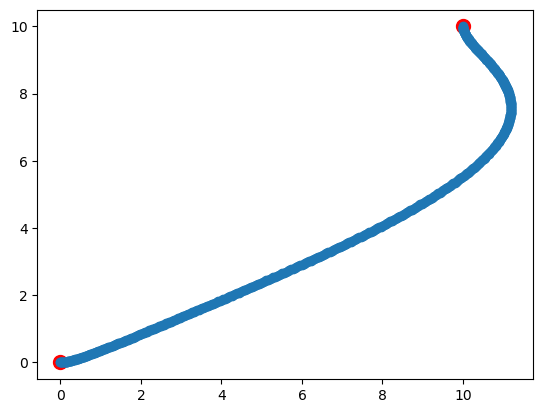

In [3]:
# Initial and final condition 

X_i = 0 # initial X
Y_i = 0 # initial Y

theta_i = 0 # initial theta
eta1_i = 0.01 # initial xd
eta2_i = 0.001 # initial yd

xi_i = 0.001 # initial xi

X_f = 10 # final X
Y_f = 10 # final Y
theta_f = math.atan2(Y_f - Y_i, X_f - X_i) # final theta

eta1_f = 0.1 # final xd
eta2_f = 0.1 # final yd
xi_f = 0 # initial xi


if jerk:

    qi = np.array([[X_i], [Y_i], [theta_i], [eta1_i], [eta2_i], [xi_i]]) 

    qf = np.array([[X_f], [Y_f], [theta_f], [eta1_f], [eta2_f], [xi_f]]) 

else:

    qi = np.array([[X_i], [Y_i], [theta_i], [eta1_i], [eta2_i]]) 

    qf = np.array([[X_f], [Y_f], [theta_f], [eta1_f], [eta2_f]]) 

KD = KinoDynamicTrajectoryPlanner(qi, qf, jerk = jerk)

KD.plan_opt_traj() # KD plan traj from initial node to the final one

plt.scatter([X_i, X_f], [Y_i, Y_f], c = 'red', s = 100)
plt.scatter([x[0] for x in KD.confs], [y[1] for y in KD.confs])
plt.show()

## RRT* Algorithm

In [4]:
class Node:
    def __init__(self, state):

        self.state = state
        self.x = state[0][0]
        self.y = state[1][0]

        self.parent = None
        self.cost = None

        self.commands = None
        self.conf = None
        self.Time = None


class KynoDynamicRRT_STAR:
    def __init__(self, start, goal, env, step, prob_gs, n_iters, obs, jerk, elevation = False):

        self.node_s = Node(start)
        self.node_g = Node(goal)

        ##################### INITIAL CONDITION #################
 
        self.node_s.Time = 0
        self.node_s.cost = 0

        self.node_s.confs = np.array([[start[0], start[1]]])
        self.node_g.confs = np.array([[goal[0], goal[1]]])

        #########################################################

        self.jerk = jerk
        self.obstacle_avoidance = obs
        self.elevation = elevation
        

        self.env = get_new_map(env, map_title[:-4])
       
        print("ENV SHAPE: ", self.env.shape)
        if env != 'basic':
            self.R, self.C = np.shape(self.env)
        print(res)
        self.n_iters = n_iters
        self.step = step
        self.prob_gs = prob_gs  #if not self.jerk else 0.2# Empirical value
        self.utils = Utils() if env == 'basic' else Utils_m(self.env, length, tol, res, pitch_bound, roll_bound, trav_map = trav_map) # Use other maps
        self.Tree = [self.node_s]
        self.plotting = Plotting(self.node_s, self.node_g, map = self.env, res = res)
        
        # Empirical values
        # self.init_radius = self.radius = min(self.R/(2*res), self.C/(2*res))

    def planning(self):
        ''' This function computes the RRT* motion planning, thanks to the utilies and KinoDynamic RRT*;
            args: ............................................................................................
            output: 
        '''

        for iter in range(self.n_iters):
            if iter % 5 == 0:
                print("N° of EXPANDED NODES: ",len(self.Tree))
            # print("Radius length: ", self.radius)
            print("ITERATION OF PLANNING N°: ",iter)

            n_rand = self.sample()
            n_nearest, n_new = self.compute_NN(n_rand)

            if n_nearest.x == n_new.x and n_nearest.y == n_new.y:
                continue
            
        
            # SET Theta
            n_new.state[2] = math.atan2(n_new.state[1] - n_nearest.state[1], n_new.state[0] - n_nearest.state[0])


            traj_planner = KinoDynamicTrajectoryPlanner(n_nearest.state, n_new.state, self.jerk) # From nearest to new
            n_new_state = traj_planner.plan_opt_traj()
            
            c = False

            # Obstacle avoidance + Elevation, high slopeness check
            if self.obstacle_avoidance:

                if not self.elevation:
                    for n in range(traj_planner.confs.shape[0]):
                        x, y = traj_planner.confs[n][0][0], traj_planner.confs[n][1][0]
                        xd, yd = traj_planner.confs[n][3][0], traj_planner.confs[n][4][0]

                        if self.utils.is_inside_obs_alternative((x, y), (xd, yd)):
                            c = True
                            break

                else:
                    prev_state = (traj_planner.confs[0][0][0], traj_planner.confs[0][1][0])
                    dist = 0
                    for n in range(1, traj_planner.confs.shape[0]):
                        
                        state = (traj_planner.confs[n][0][0], traj_planner.confs[n][1][0])
                        vels = traj_planner.confs[n][3][0], traj_planner.confs[n][4][0]
                        check = self.utils.is_transition_feasible(prev_state, state, vels)
                 
                        if check[0]:
                        
                            c = True
                            break
                        dist += check[-1]
                        prev_state = state
                    traj_planner.elev = dist
                
            if c:
                c = False
                continue
            
            n_new = Node(n_new_state)
            if int(round(n_new.x)) in range(0, self.utils.x_range) and int(round(n_new.y)) in range(0, self.utils.y_range):
                # Assign to node velocity, acceleration and commands
                n_new.commands = traj_planner.commands
                n_new.confs = traj_planner.confs
                n_new.cost = traj_planner.cost if not self.elevation else traj_planner.cost + traj_planner.elev
                n_new.Time = traj_planner.Time

                N_near = self.compute_NN(n_new, near=True)
                # N_near = self.Tree
                n_min, cost_min, n_new = self.choose_parent(N_near, n_nearest, n_new)
                n_new.parent = n_min
                n_new.cost = cost_min
                # Insert Node
                self.Tree.append(n_new)
                self.rewire(N_near, n_min, n_new)
                
                # # RADIUSS #
                # self.radius = self.compute_radius(len(self.Tree)) 
                # ############

        path = [[self.node_g]]
        goal_state = self.get_goal_state()
        self.tot_path = self.compute_path(path, goal_state)

        self.plotting.animation(self.Tree, self.tot_path,
                                "KRRT* on the {} map, N = {}".format(map_title[:-4], str(self.n_iters)), steer = True)
        print("END OF THE ITERATIONS\n N° EXPANDED NODES: ",len(self.Tree))
        
        

    def choose_parent(self, N_near, n_nearest, n_new):
        ''' This function change the parent of n_new, starting with an initial guess on its nearest neighbor.;
            args: (N_near : List of n_new's neighbors), (n_nearest : n_new's initial guess as a parent.),
                  (n_new : Node object that need to be assigned at a node in N_near).
            output: 
        '''
        n_parent = n_nearest
        # Init. guess parent for sampled node
        cost_min = n_nearest.cost + n_new.cost#self.compute_cost(n_new.confs)
        for n_near in N_near:

            if n_near.x == n_new.x and n_near.y == n_new.y:
                continue
            
            n_new_tr = copy.copy(n_new)
            # SET Theta
            n_new_tr.state[2] = math.atan2(n_new_tr.state[1] - n_near.state[1], n_new_tr.state[0] - n_near.state[0])

            traj_planner = KinoDynamicTrajectoryPlanner(n_near.state, n_new_tr.state, self.jerk) # From nearest to new
            traj_planner.plan_opt_traj()

            c = False
            # Obstacle avoidance + Elevation, high slopeness check
            if self.obstacle_avoidance:
                if not self.elevation:
                    for n in range(traj_planner.confs.shape[0]):
                        x, y = traj_planner.confs[n][0][0], traj_planner.confs[n][1][0]
                        xd, yd = traj_planner.confs[n][3][0], traj_planner.confs[n][4][0]
                        if self.utils.is_inside_obs_alternative((x, y), (xd, yd)):    # print('found obs: ', iter)
                            c = True
                            break
                else:
                    prev_state = (traj_planner.confs[0][0][0], traj_planner.confs[0][1][0])
                    dist = 0
                    for n in range(1, traj_planner.confs.shape[0]):
                        state = (traj_planner.confs[n][0][0], traj_planner.confs[n][1][0])
                        vels = traj_planner.confs[n][3][0], traj_planner.confs[n][4][0]
                        check = self.utils.is_transition_feasible(prev_state, state, vels)
                        if check:
                            c = True
                            break
                        dist += check[-1]
                    traj_planner.elev = dist
                
            if c:
                continue
                
            
            if int(round(n_new_tr.x)) in range(0, self.utils.x_range) and int(round(n_new_tr.y)) in range(0, self.utils.y_range):

                inter_cost = n_near.cost + \
                   traj_planner.cost if not self.elevation else n_near.cost + traj_planner.cost + traj_planner.elev
                if inter_cost < cost_min:
                    n_parent = n_near         # New best alternative
                    cost_min = inter_cost

                    n_new.Time = traj_planner.Time
                    n_new.confs = traj_planner.confs
                    n_new.commands = traj_planner.commands
                    n_new.cost = inter_cost

                    n_new.state[2] = n_new_tr.state[2] 
                    n_new.x, n_new.y = n_new_tr.x, n_new_tr.y

        


        return n_parent, cost_min, n_new

    def rewire(self, N_near, n_parent, n_new):
        ''' This function change the parent of the n_new's neighbors iff n_new is a better parent than their current ones. ;
            args: (N_near : List of n_new's neighbors), (n_parent : n_new's parent is not considered in the computation.),
                  (n_new : Candidate parent, for the nodes in N_near).
            output: ........................................................................................................
        '''
        # N_near = N_near[:10]
        for n_near in N_near:
            if n_near.x == n_parent.x and n_near.y == n_parent.y:
                continue

            if n_near.x == n_new.x and n_near.y == n_new.y:
                continue
            
            n_near_tr = copy.copy(n_near)
            # SET Theta
            n_near_tr.state[2] = math.atan2(n_near_tr.state[1] - n_new.state[1], n_near_tr.state[0] - n_new.state[0])
            traj_planner = KinoDynamicTrajectoryPlanner(n_new.state, n_near_tr.state, self.jerk) # From nearest to new
            traj_planner.plan_opt_traj()
            c = False

            # Obstacle avoidance + Elevation, high slopeness check
            if self.obstacle_avoidance:
                if not self.elevation:
                    for n in range(traj_planner.confs.shape[0]):
                        x, y = traj_planner.confs[n][0][0], traj_planner.confs[n][1][0]
                        xd, yd = traj_planner.confs[n][3][0], traj_planner.confs[n][4][0]

                        if self.utils.is_inside_obs_alternative((x, y), (xd, yd)):    # print('found obs: ', iter)
                            c = True
                            break
                else:
                    prev_state = (traj_planner.confs[0][0][0], traj_planner.confs[0][1][0])
                    dist = 0
                    for n in range(1, traj_planner.confs.shape[0]):
                        state = (traj_planner.confs[n][0][0], traj_planner.confs[n][1][0])
                        vels = traj_planner.confs[n][3][0], traj_planner.confs[n][4][0]
                        check = self.utils.is_transition_feasible(prev_state, state, vels)
                        if check:
                            c = True
                            break
                        dist += check[-1]
                    traj_planner.elev = dist
                
            if c:
                continue

            z_near = n_near_tr
            go = False
            if int(round(z_near.x)) in range(0, self.utils.x_range) and int(round(z_near.y)) in range(0, self.utils.y_range):
                
                if not self.elevation:

                    if (n_new.cost + traj_planner.cost < n_near.cost): #traj_planner.cost#self.compute_cost(traj_planner.confs)
                        go = True
                elif self.elevation:
                    if (n_new.cost + traj_planner.cost + traj_planner.elev < n_near.cost): #traj_planner.cost#self.compute_cost(traj_planner.confs)
                        go = True
                        
                if go:
                    z_near.parent = n_new
                    z_near.cost = n_new.cost + traj_planner.cost # #self.compute_cost(traj_planner.confs)
                    z_near.Time = traj_planner.Time

                    n_near_old_idx = self.Tree.index(n_near)
                    self.Tree[n_near_old_idx] = z_near

                    z_near.commands = traj_planner.commands
                    z_near.confs = traj_planner.confs

                    self.Tree.append(z_near)    
                
        return

    def compute_NN(self, n_curr, near=False):
        ''' This function has two main objectives, either to compute a nearest neighbor, and also to compute a set of nearest neighbors. ;
            args: (n_curr : Node object, current node), (near : If True, are computed the neighbors for n_curr given a certain radius.)
            output: n_nearest, n_new XOR node_list
        '''
        
        
        
        dist_list = np.array([self.compute_dist_NN(n_curr, n_tree)
                             for n_tree in self.Tree])
        dist_list2 = sorted([self.compute_dist_NN(n_curr, n_tree) for n_tree in self.Tree])

        dist = dist_list2[10] if len(dist_list2) > 10 else dist_list2[-1]


        if not near:  # Nearest

            n_nearest = self.Tree[np.argmin(dist_list)]
            dist = min(np.min(dist_list), self.step)
            # dist = np.min(dist_list)

            theta = math.atan2(n_curr.y-n_nearest.y, n_curr.x - n_nearest.x)

            if self.jerk:
                state = np.array([[(n_nearest.x + dist*math.cos(theta))], [(n_nearest.y + dist*math.sin(theta))],
                                [n_curr.state[2][0]], [n_curr.state[3][0]], [n_curr.state[4][0]], [n_curr.state[5][0]]])
                # state = np.array([[n_curr.state[0][0]], [n_curr.state[1][0]],
                #                 [n_curr.state[2][0]], [n_curr.state[3][0]], [n_curr.state[4][0]], [n_curr.state[5][0]]])
            else:
                state = np.array([[(n_nearest.x + dist*math.cos(theta))], [(n_nearest.y + dist*math.sin(theta))],
                               [n_curr.state[2][0]], [n_curr.state[3][0]], [n_curr.state[4][0]]])
                # state = np.array([[n_curr.state[0][0]], [n_curr.state[1][0]],
                #                 [n_curr.state[2][0]], [n_curr.state[3][0]], [n_curr.state[4][0]]])
   
            n_new = Node(state)

            return n_nearest, n_new
        else:        # Near
            node_list = [self.Tree[idx] for idx in range(
                len(dist_list)) if dist_list[idx] < dist]
            # node_list = [random.choice(self.Tree) for i in range(50)]

            return node_list

    def sample(self):
        ''' Sample function RRT*, sample the goal node with a low probability '''
        if np.random.random() > self.prob_gs:

            x_new = np.random.uniform(self.R/res)
            y_new = np.random.uniform(self.C/res)
            xd_new = np.random.uniform(low = 0.1, high = 0.3)
            yd_new = 0
            theta_new = 0 

            if not self.jerk:
                state = np.array([[x_new], [y_new], [theta_new], [xd_new], [yd_new]])
            else:
                xi_new = 0
                state = np.array([[x_new], [y_new], [theta_new], [xd_new], [yd_new], [xi_new]])

         
            return Node(state)

        return self.node_g

    def get_goal_state(self):
        ''' This function the closest state to the goal state, that was found during the algorithm;
            args: ........................................................................
            output: goal_state: Node object
        '''
        dist_list = np.array([self.compute_dist_NN(node, self.node_g, pos = True)
                             for node in self.Tree])
        min_idx = np.argmin(dist_list)
        goal_state = self.Tree[min_idx]

        return goal_state

    def compute_path(self, path, goal_state):
        ''' This function fills the path between the start and goal state, it considers that each node has a parent ;
            args: (path : empty path), (goal_state : pre-computed goal node, which is the closest to the actual goal node.)
            output: path : complete path e.g. [[Node_g], [Node_g-1], ......, [Node_start]]
        '''
        
        n_curr = goal_state

        while n_curr.x != self.node_s.x or n_curr.y != self.node_s.y:
            path.append([n_curr])
            n_curr = n_curr.parent

        path.append([n_curr])

        return path

    def compute_dist_NN(self, n1, n2, pos = False):
        ''' This function computes the euclidean distance between two object of the Node class 
            args: n1, n2 : n_i is an instance of Node ;
            
            output: dist : Total distance (m)

        '''
        if not pos:
            dist = np.linalg.norm(n1.state - n2.state)
        else:
            dist = np.linalg.norm(n1.state[:2]-n2.state[:2])


        return dist

    def compute_dist(self, conf):
        ''' This function takes a trajectory of positions, and computes the distance (m) the links these coordinates 
            args: conf : [(x_0, y_0), (x_1, y_1), ......, (x_f, y_f)];
            
            output: dist : Total distance (m)

        '''
        dist = 0

        dist_func = lambda p1, p2: math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

        for pt in range(1, conf.shape[0]):
            dist += dist_func(conf[pt], conf[pt - 1])
        return dist

    def compute_cost(self, conf):
        ''' This function takes a trajectory of positions, and computes the cost to do such trajectory, it is also used an elevation map. 
            args: conf : np.array([[x_0, y_0, theta_0, eta10, eta20],.....,[x_f, y_f, theta_f, eta1f, eta2f]];
            
            output: cost : Total distance (m)

        '''
        plan_dist = self.compute_dist(conf)  # Planar distance

        cost = plan_dist

        return cost 
    
    # def compute_radius(self, n):
    #     radius = self.init_radius * (math.log(n) / n)**(1/(self.node_s.state.shape[0])) #, self.step)
    #     return radius
    
    def compute_stats(self):
        self.commands = []
        self.confs = []
        self.confs_array = []
        self.command_array = []

        self.vels = []
        self.accs = []
        self.accs_robF = []
        self.tau = []
        self.time = 0
        self.tot_cost = 0
        path = list(reversed(self.tot_path[1:-1]))

        for node in path:
            self.time += node[0].Time
            conf = node[0].confs
            command = node[0].commands
            self.tot_cost += node[0].cost
            
            for state in range(conf.shape[0]-1):
                if not self.jerk:
                    self.confs.append((conf[state][0], conf[state][1], conf[state][2], conf[state][3], conf[state][4]))
                    rot = self.rotation(conf[state][2])
                    Qd = rot @ np.array([conf[state][3],
                                         conf[state][4]])
                    self.vels.append((Qd[0], Qd[1]))

                    u1 = command[state][0]
                    u2 = command[state][1]

                    Qdd = rot @ np.array([u1 - (conf[state][4]**2)/d0,
                                         u2 - (conf[state][3]*conf[state][4])/d0])
                    self.accs.append((Qdd[0], Qdd[1]))
                    self.accs_robF.append((u1, u2))
                    if len(self.confs_array) == 0:
                        self.confs_array = np.array([conf[state][0], conf[state][1], conf[state][2], conf[state][3], conf[state][4]])
                        self.command_array = np.array([u1, u2])
                    else:
                        self.confs_array = np.concatenate((self.confs_array, np.array([conf[state][0], conf[state][1], conf[state][2], conf[state][3], conf[state][4]])))
                        self.command_array = np.concatenate((self.command_array, np.array([u1, u2])))


                
                else:
                    self.confs.append((conf[state][0], conf[state][1], conf[state][2], conf[state][3], conf[state][4], conf[state][5]))
                    rot = self.rotation(conf[state][2])
            
                    Qd = rot @ np.array([conf[state][3],
                                         conf[state][4]])
                    self.vels.append((Qd[0], Qd[1]))

                    u1 = conf[state][5]
                    u2 = (d0/conf[state][3])*(math.sin(conf[state][2])*command[state][0]  - \
                            math.cos(conf[state][2])*command[state][1]) - (2/conf[state][3])*u1*conf[state][4]

                    Qdd = rot @ np.array([u1 - (conf[state][4]**2)/d0,
                                         u2 - (conf[state][3]*conf[state][4])/d0])
                    self.accs.append((Qdd[0], Qdd[1]))
                    self.accs_robF.append((u1, u2))
                    tau1, tau2 = self.compute_tau(conf[state][3], conf[state][4], -(conf[state][4]/d0), u1, u2)

                    self.tau.append((tau1, tau2))
                    if len(self.confs_array) == 0:
                        self.confs_array = np.array([conf[state][0], conf[state][1], conf[state][2], conf[state][3], conf[state][4], conf[state][5]]).T
                        self.command_array = np.array([u1, u2])
                    else:
                        
                        self.confs_array = np.concatenate((self.confs_array, np.array([conf[state][0], conf[state][1], conf[state][2], conf[state][3], conf[state][4], conf[state][5]]).T))
                        self.command_array = np.concatenate((self.command_array, np.array([u1, u2])))



                self.commands.append((command[state][0], command[state][1]))
            self.commands.append((command[-1][0], command[-1][1]))

        print("Total time of the trajectory is: ", self.time, " seconds")
        print("Number of nodes traversed is: ", len(self.tot_path))
        print("Total cost of the path is: ", self.tot_cost)


    
    @staticmethod
    def rotation(theta):
        Rot = np.array([[math.cos(theta), -math.sin(theta)],
                      [math.sin(theta), math.cos(theta)]])
        
        return Rot
    
    @staticmethod
    def compute_friction(xd, yd, thetad):
        '''This function computes the resistive force on the x axis Rx, the viscous friction on the y axis Fy and the resistive moment Mr'''
        x1d = x4d = xd - t*thetad
        x3d = x2d = xd + t*thetad

        y1d = y2d = yd + a*thetad

        y3d = y4d = yd - b*thetad

        Rx = fr * (mass * g)/2 * (np.sign(x1d) + np.sign(x2d))

        Fy = mu * ((mass*g)/(a + b)) * \
                (b*np.sign(y1d) + a*np.sign(y3d))

        Mr = mu * ((a*b*mass*g)/(a + b))*(np.sign(y1d) -
                                                np.sign(y3d)) + fr*t*mass*g/2*(np.sign(x2d) - np.sign(x1d))
        return Rx, Fy, Mr
    
    def compute_tau(self, xd, yd, thetad, u1, u2):

            Rx, Fy, Mr = self.compute_friction(xd, yd, thetad)
            
            t1 =r/2*(mass * u1 + (mass/d0) * (yd**2) +Rx) - ((r*d0) / (
                    2*t)) * ((mass + (Iz/d0**2)) * u2 - (mass/d0)*xd*yd+ Fy - Mr/d0) 
            t2= r/2*(mass * u1 + mass/d0 * (yd**2) +Rx) + ((r*d0) / (
                    2*t)) * ((mass + (Iz/d0**2)) * u2 - (mass/d0)*xd*yd + Fy - Mr/d0)
            
            t1 = np.clip(t1, -tau_max, tau_max)
            t2 = np.clip(t2, -tau_max, tau_max)

            return t1, t2

## Initial state and planning

In [8]:
env = np.load('numpy_maps/'+map_title) #'basic' #Env(x_bounds=x_bounds, y_bounds=y_bounds)#np.load('numpy_maps/lunar_tranquillitatis_pit.npy')
    

theta_i = math.atan2(goal[1] -goal[0], start[1] - start[0])
eta1_i = 0.2
eta2_i = 0.05
xi_i = 0.001


theta_f = 10 
eta1_f = 0.07
eta2_f = 0.001
xi_f = 0.001


####### For motion planning with jerk set this boolean to True
jerk = False

if jerk:

    qi = np.array([[start[0]], [start[1]], [theta_i], [eta1_i], [eta2_i], [xi_i]]) 

    qf = np.array([[goal[0]], [goal[1]], [theta_f], [eta1_f], [eta2_f], [xi_f]]) 
else:
    qi = np.array([[start[0]], [start[1]], [theta_i], [eta1_i], [eta2_i]]) 

    qf = np.array([[goal[0]], [goal[1]], [theta_f], [eta1_f], [eta2_f]]) 
obs = True
n_iters = 1
rrt = KynoDynamicRRT_STAR(qi, qf, env, step, prob_gs, n_iters, obs, jerk, elevation = elevation) 

ENV SHAPE:  (300, 300)
10


/tmp/ipykernel_22935/1913328681.py:40: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if env != 'basic':
/tmp/ipykernel_22935/1913328681.py:46: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  self.utils = Utils() if env == 'basic' else Utils_m(self.env, length, tol, res, pitch_bound, roll_bound, trav_map = trav_map) # Use other maps


In [9]:
first = False
if not first:
    rrt.Tree = list(np.load('simulations/'+map_title[:-4]+'/acceleration/tree.npy', allow_pickle = True))

N° of EXPANDED NODES:  3972
ITERATION OF PLANNING N°:  0


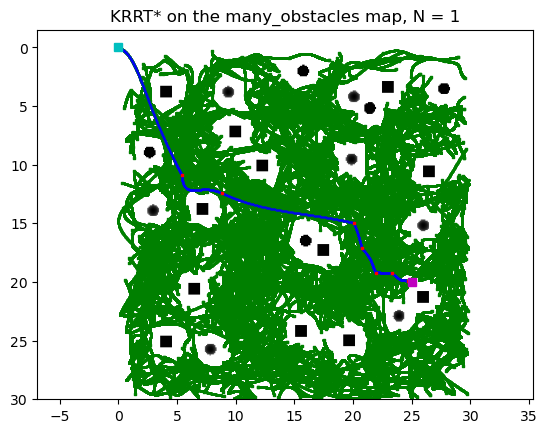

END OF THE ITERATIONS
 N° EXPANDED NODES:  3972


In [10]:
e = rrt.planning()   # 13000 
np.save('simulations/'+map_title[:-4]+'/acceleration/tree.npy', rrt.Tree)

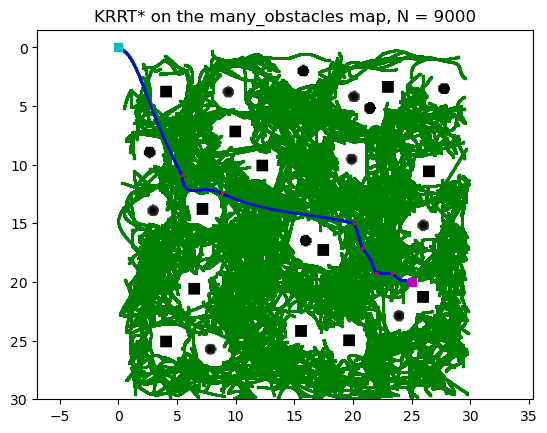

END OF THE ITERATIONS
 N° EXPANDED NODES:  3972


In [12]:
path = [[rrt.node_g]]
goal_state = rrt.get_goal_state()
rrt.tot_path = rrt.compute_path(path, goal_state)

rrt.plotting.animation(rrt.Tree, rrt.tot_path,
                        "KRRT* on the {} map, N = {}".format(map_title[:-4],9000), steer = True)
print("END OF THE ITERATIONS\n N° EXPANDED NODES: ",len(rrt.Tree))

In [11]:
rrt.compute_stats()

Total time of the trajectory is:  131.0  seconds
Number of nodes traversed is:  9
Total cost of the path is:  800.4516937739787


# Controller

## Commands plot

In [29]:
######## Acceleration case ########
k_eta1 = 3.5
k_p1 = 5
k_ptheta = 2.0
k_dtheta = 1.0


######## Jerk case ###############
if jerk:
    kv = 0#if jerk == True else 1
    kp = 0 # *kv
    ka = 0# 0.1*kv # ka

In [30]:
class State_Reconstruction:

    def __init__(self, des_confs, des_comm, des_accs, jerk):

        self.des_confs = des_confs
        self.des_comm = des_comm
        self.des_accs = des_accs

        self.jerk = jerk

    def RK4(self, f, x0, u, dt, A, B):
        k1 = f(x0, u, A, B)
        k2 = f(x0 + k1 * dt / 2.0, u, A, B)
        k3 = f(x0 + k2 * dt / 2.0, u, A, B)
        k4 = f(x0 + k3 * dt, u, A, B)
        yf = x0 + dt / 6.0 * (k1 + 2.0 * k2 + 2.0 * k3 + k4)
        return yf
    
    def RK4_(self, f, x0, u, dt):
        
        k1 = f(x0, u)

        k2 = f(x0 + k1 * dt / 2.0, u)
        k3 = f(x0 + k2 * dt / 2.0, u)
        k4 = f(x0 + k3 * dt, u)
        
        yf = x0 + dt / 6.0 * (k1 + 2.0 * k2 + 2.0 * k3 + k4)

        return yf

    
    
    def get_state(self, q, u):
        x = q[0]
        y = q[1]
        theta = q[2]
        eta1 = q[3]
        eta2 = q[4]
        # print("eta1", eta1)
        # print("eta2", eta2)
        xdot = eta1 * math.cos(theta) - eta2 * math.sin(theta)
        ydot = eta1 * math.sin(theta) + eta2 * math.cos(theta)
        thetadot = -eta2/d0   
        

        if not self.jerk:
            eta1dot = u[0]
            eta2dot = u[1]
            qdot = np.array([xdot, ydot, thetadot, eta1dot, eta2dot])
        else:
            r1 = u[0]
            r2 = u[1]
            eta1_dot = q[-1]
            xi = q[-1]
            eta2_dot = d0 / eta1 * (math.sin(theta) * r1 - math.cos(theta) * r2) - 2.0 * xi * eta2 / eta1
            xi_dot = math.cos(theta) * r1 + math.sin(theta) * r2 + 1 / (d0**2) * eta1 * (eta2**2)
            qdot = np.array([xdot, ydot, thetadot, eta1_dot, eta2_dot, xi_dot])
        return qdot

    
    def rec_states(self):

        # Initial condition
        q_c = np.array([coord[0] for coord in self.des_confs[0]]) 
        # q_c[0]+= 0.5
        # q_c[1]+= 0.02
        # q_c[2]+= 0.23
        
        

        self.q_real = []
        self.errors = []

        self.theta = []
        self.eta1 = []
        self.eta2 = []
        self.xi = []
        self.r1 = []
        self.r2 = []
        self.u1 = []
        self.u2 = []
        self.r_acc = []
        self.d_acc = []

        self.ep = []
        self.ev = []
        self.ea = []
        self.tau = []

        self.error_x = []
        self.error_y = []
        self.error_theta = []
        self.error_eta1 = []
        self.error_eta2 = []

        ep = np.array([0,0])
        ev = np.array([0,0])
        ea = np.array([0,0])

        eEta1 = 0
        eEta2 = 0
        ex = 0
        ey = 0
        e_theta = 0


        self.real_commands = []
        for (state, command, accs) in zip(self.des_confs[1:], self.des_comm, self.des_accs):

            if not self.jerk:
                state = np.array([state[0][0], state[1][0], state[2][0], state[3][0], state[4][0]])
            else:
                z1, z2, z1d, z2d, z1dd, z2dd = self.compute_ext_dyn(state[0][0], state[1][0], state[2][0], state[3][0], state[4][0], accs[0], accs[1])
                state = np.array([z1, z2, state[2][0], z1d, z2d, z1dd[0], z2dd[0]])

            command = np.array([command[0][0], command[1][0]])
            
                       
            if self.jerk: 

                r = command +  kp * ep + kv * ev + ka * ea
        
                              
                u1 = q_c[-1]
                u2 = d0/q_c[3]*(math.sin(q_c[2])*r[0] - math.cos(q_c[2])*r[1]) - 2/q_c[3]*u1*q_c[4]

                command[0] = u1
                command[1] = u2
                
                real_acc = np.array([u1, u2])
                des_acc = np.array([accs[0], accs[1]])

                # ea[0] = (des_acc[0][0] + (state[4]**2)/d0) - (real_acc[0] + (q_c[4]**2)/d0)
                # ea[1] = (des_acc[1][0] - (state[3]*state[4])/d0) - (real_acc[1] - (q_c[3]*q_c[4])/d0)

                self.r_acc.append(real_acc)
                self.d_acc.append(des_acc)
                self.ep.append(ep)
                self.ev.append(ev)
                self.ea.append(ea)
                self.r1.append(r[0])
                self.r2.append(r[1])
                self.u1.append(u1)
                self.u2.append(u2)
                self.xi.append(q_c[5])
   
            else:
            
                # command += kp * self.rotation(q_c[2]).T@ep + kv*ev 
                command[0] += k_eta1 * (eEta1) + k_p1 * ex
                command[1] = -d0*(-command[1]/d0 + k_ptheta * self.wrap_angle(e_theta) + k_dtheta*(-state[4]/d0 + q_c[4]/d0)) #kv[1] * (eEta2) + kp[1] * ey
              
    
            #print("Commands", command)
            # command[0] = np.clip(command[0], -0.1, 0.1)
            # command[1] = np.clip(command[1], -0.05, 0.05)


            if not self.jerk:
                t1, t2 = self.compute_tau(q_c[3], q_c[4], -q_c[4]/d0, command[0], command[1])
                self.tau.append((t1, t2))

            for i in range(10):
                q_c = self.RK4_(self.get_state, q_c, command, 1/(10*freq))
    
            # q_c = self.RK4_(self.get_state, q_c, command, 1/(freq))
            if self.jerk:
                z_real = self.compute_ext_dyn(q_c[0], q_c[1], q_c[2], q_c[3], q_c[4], u1, u2)
                
            
            q_c[2] = self.wrap_angle(q_c[2])
                       
            if self.jerk: 
                ep[0] = z1 - z_real[0]
                ep[1] = z2 - z_real[1] 

                ev[0] = z1d - z_real[2] 
                ev[1] = z2d - z_real[3] 
                
                ea[0] = z1dd[0] - z_real[4] 
                ea[1] = z2dd[0] - z_real[5]
            else:
                e = state - q_c
                theta = q_c[2]
            
                ex = e[0]*math.cos(theta) + e[1]*math.sin(theta)
                ey = - e[0]*math.sin(theta) + e[1]*math.cos(theta)

                eEta1 = e[3]
                eEta2 = e[4]

                e_theta = e[2]
                self.errors.append(e)
            self.error_x.append(ex)
            self.error_y.append(ey)
            self.error_y.append(e_theta)
            self.error_eta1.append(eEta1)
            self.error_eta2.append(eEta2)
            
            self.theta.append(q_c[2])
            self.eta1.append(q_c[3])
            self.eta2.append(q_c[4])
            self.q_real.append(np.expand_dims(q_c, axis=1))
            
            


            self.real_commands.append(([command[0]], [command[1]]))

    
    def compute_ext_dyn(self, x, y, theta, xd, yd, xdd, ydd):
        '''This function compute the dynamic extension of the skid steering robot moving the control point of a distance
           d0 longitudinal with respect the x axis'''
        
        z1_ = x + d0 * math.cos(theta)
        z2_ = y + d0 * math.sin(theta)
        thetad = - yd/d0
        
        z1d_ = xd*math.cos(theta) - yd*math.sin(theta) - \
                d0*math.sin(theta)*thetad
        z2d_ = xd*math.sin(theta) + yd*math.cos(theta) + \
                d0*math.cos(theta)*thetad
        
        thetadd = - ydd/d0

        z1dd_ = (xdd - yd*thetad)*math.cos(theta) - (ydd + xd*thetad)*math.sin(theta) - \
            d0*math.cos(theta)*(thetad**2) - d0*math.sin(theta)*thetadd

        z2dd_ = (xdd - yd*thetad)*math.sin(theta) + (ydd + xd*thetad)*math.cos(theta) - \
            d0*math.sin(theta)*(thetad**2) + d0*math.cos(theta)*thetadd 
      
        return z1_, z2_, z1d_, z2d_, z1dd_, z2dd_

    def plot_quantities(self, trend_list, tup_shape, title_list, title, zero = False): # zero True if the tuple have numbers instead of arrays.
    
        x= np.linspace(0, len(trend_list[0]), len(trend_list[0]))
        d = {0:'des', 1: 'real', 2: ''}

        fig = make_subplots(rows=tup_shape[0], cols=tup_shape[1])
        
        for fig1 in range(tup_shape[0]):
            for fig2 in range(tup_shape[-1]):
                c = 0 if len(trend_list) > 1 else 2
                for trend in trend_list:
                    if zero:
                        print(trend[0][fig1+fig2])
                        y = [x[fig1 + fig2] for x in trend]
                    else:

                        y = [x[fig1 + fig2][0] for x in trend]

                    fig.add_trace(go.Scatter(x=x, y=y, name=title_list[fig1 + fig2] + ' ' + d[c]), row=fig1 + 1, col=fig2 + 1)
                    c+=1
        
        fig.update_layout(height=500, width=600, title_text=title)

        fig.show()

    def wrap_angle(self, theta):
        return math.atan2(math.sin(theta), math.cos(theta))

    def plot_stuff(self):
        if self.jerk: 
            self.plot_quantities([self.des_confs], (6, 1), ['X', 'Y', 'Theta', 'xd', 'yd', 'xdd'], 'Configuration (jerk)')
            self.plot_quantities([self.des_confs, self.q_real], (6, 1), ['X', 'Y', 'Theta', 'xd', 'yd', 'xdd'], 'Configuration recovery (jerk)')
            self.plot_quantities([self.errors], (6, 1), ['X error', 'Y error', 'Theta error', 'xd error', 'yd error', 'xdd error'], 'Error (jerk)', zero = True)
            self.plot_quantities([self.des_accs, self.real_commands], (2, 1), ['Xdd', 'Ydd'], 'Accelerations (jerk mode)' if self.jerk == True else 'Accelerations', zero = True)

            #plt.plot(self.eta1)
            #plt.plot(self.eta2)
            #plt.plot(self.theta)
            #plt.plot(self.xi)
            #plt.plot(self.real_commands)
            #plt.plot(self.r1)
            #plt.plot(self.r2)
            #plt.plot(self.u1)
            #plt.plot(self.u2)
            #plt.plot(self.d_acc)
            #plt.plot(self.r_acc)
            #plt.plot(self.ep)
            #plt.plot(self.ev)
            #plt.plot(self.ea)

            
        else:
            self.plot_quantities([self.des_confs], (5, 1), ['X', 'Y', 'Theta', 'xd', 'yd'], 'Configuration')
            self.plot_quantities([self.des_confs, self.q_real], (3, 1), ['X', 'Y', 'Theta', 'xd', 'yd'], 'Configuration recovery')
            self.plot_quantities([self.errors], (3, 1), ['X error', 'Y error', 'Theta error', 'xd error', 'yd error'], 'Error', zero = True) 
            self.plot_quantities([self.des_accs, self.real_commands], (2, 1), ['Xdd', 'Ydd'], 'Accelerations')
            self.plot_quantities([self.tau], (2, 1), ['Tau1', 'Tau2'], 'Real Torques', zero = True)



            #plt.plot(self.error_x)
            #plt.plot(self.error_y)
            #plt.plot(self.error_theta)
            #plt.plot(self.error_eta1)
            #plt.plot(self.error_eta2)
        
        
    def compute_friction(self, xd, yd, thetad):
        '''This function computes the resistive force on the x axis Rx, the viscous friction on the y axis Fy and the resistive moment Mr'''
        x1d = x4d = xd - t*thetad
        x3d = x2d = xd + t*thetad

        y1d = y2d = yd + a*thetad

        y3d = y4d = yd - b*thetad

        Rx = fr * (mass * g)/2 * (np.sign(x1d) + np.sign(x2d))

        Fy = mu * ((mass*g)/(a + b)) * \
                (b*np.sign(y1d) + a*np.sign(y3d))

        Mr = mu * ((a*b*mass*g)/(a + b))*(np.sign(y1d) -
                                                np.sign(y3d)) + fr*t*mass*g/2*(np.sign(x2d) - np.sign(x1d))
        return Rx, Fy, Mr
    
    def compute_tau(self, xd, yd, thetad, u1, u2):

            Rx, Fy, Mr = self.compute_friction(xd, yd, thetad)
            
            t1 =r/2*(mass * u1 + (mass/d0) * (yd**2) +Rx) - ((r*d0) / (
                    2*t)) * ((mass + (Iz/d0**2)) * u2 - (mass/d0)*xd*yd+ Fy - Mr/d0) 
            t2= r/2*(mass * u1 + mass/d0 * (yd**2) +Rx) + ((r*d0) / (
                    2*t)) * ((mass + (Iz/d0**2)) * u2 - (mass/d0)*xd*yd + Fy - Mr/d0)
            
            # t1 = np.clip(t1, -tau_max, tau_max)
            # t2 = np.clip(t2, -tau_max, tau_max)

            return t1, t2


    @staticmethod
    def rotation(theta):
        Rot = np.array([[math.cos(theta), -math.sin(theta)],
                      [math.sin(theta), math.cos(theta)]])
        return Rot
        

In [32]:
g = 9.81

In [33]:
evaluate = State_Reconstruction(rrt.confs, rrt.commands, rrt.accs_robF, jerk)
evaluate.rec_states()
evaluate.plot_stuff()

-0.0016625230944124084
0.0030173573309559987
-5.646223714899377e-05


-118.71875091607158
142.01871998107492


## Plotting

In [49]:
simulation_tit = 'simulations/' + map_title[:-4]+ '/1500_iters_acc/'



def save_simulation(sim_name):
    title1 = 'confs.npy'
    title2 = 'commands.npy'
    title3 = 'tau.npy'
    title4 = 'tree.npy'


    np.save(sim_name+title1, rrt.confs)
    np.save(sim_name+title2, rrt.commands)
    np.save(sim_name+title3, rrt.tau)
    np.save(sim_name+title4, rrt.Tree)

# np.save(simulation_tit+title, rrt.confs)

In [50]:
save_simulation(simulation_tit)

In [51]:
tt = np.load(simulation_tit+'tree.npy', allow_pickle=True)